In [1]:
import pm4py
import math
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from pm4py.objects.log.util import general as log_util
from pm4py.objects.log.util import xes
import tkinter
import matplotlib 
matplotlib.use('TkAgg')
import seaborn as sns
import collections

In [2]:
from pm4py.algo.discovery.inductive.util import shared_constants
shared_constants.NOISE_THRESHOLD

0.2

In [3]:
# Importing a XES event log
from pm4py.objects.log.importer.xes import factory as xes_importer

log = xes_importer.import_log('/home/tsai/pm4py_mod/CompleteTraceDetection/BPI_2017A.xes')


In [4]:
from pm4py.objects.log.util import sorting
from pm4py.objects.conversion.log.versions import to_event_stream
from pm4py.objects.conversion.log.versions import to_event_log
from pm4py.objects.log import log as log_instance
case_glue=log_util.CASE_ATTRIBUTE_GLUE
es1 = to_event_stream.transform_event_log_to_event_stream(log)
es2 = sorting.sort_timestamp_stream(es1)

In [ ]:
for event_index,event in enumerate(sorting.sort_timestamp_stream(es2)):
    print("case:concept:name: %s  event activity: %s  timestamp: %s" % (event['case:concept:name'], event["concept:name"],event["time:timestamp"]))

In [5]:
from pm4py.algo.filtering.log.variants import variants_filter
# var=variants_filter.get_variants(gen_log)
var=variants_filter.get_variants_sorted_by_count(variants_filter.get_variants(log))
# var

In [ ]:
es2.__len__()

In [6]:
#  length of each trace (dict)
tr_len = {}
for case_index, case in enumerate(log):
    tr_len[case.attributes[xes.DEFAULT_TRACEID_KEY]]=log[case_index].__len__()

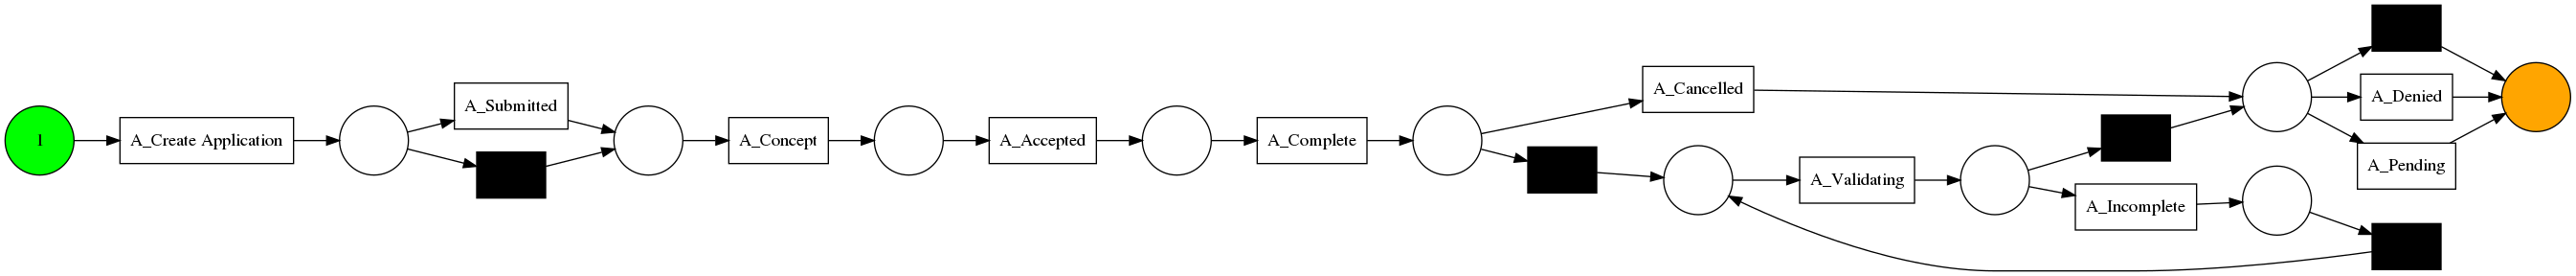

In [7]:
# Mining for a Petri net
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.algo.discovery.inductive.versions.log import basic
from pm4py.algo.discovery.inductive.versions.dfg import dfg_based
net, initial_marking, final_marking = basic.apply(log)
# net, initial_marking, final_marking = dfg_based.apply(log)
# Petri net visualization
from pm4py.visualization.petrinet import factory as pn_vis_factory

gviz_pn = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz_pn)
# pn_vis_factory.save(gviz_pn,'/home/tsai/Dropbox/Process_Mining/OutputData/W18/Real_life/BPI_2017A.png')

In [8]:
basic.apply_tree(log)

->( 'A_Create Application', X( 'A_Submitted', τ ), 'A_Concept', 'A_Accepted', 'A_Complete', X( *( 'A_Validating', 'A_Incomplete' ), 'A_Cancelled' ), X( 'A_Denied', 'A_Pending', τ ) )

In [9]:
variants_filter.get_variants_sorted_by_count(variants_filter.get_variants(log))

[['A_Create Application,A_Submitted,A_Concept,A_Accepted,A_Complete,A_Cancelled',
  804],
 ['A_Create Application,A_Submitted,A_Concept,A_Accepted,A_Complete,A_Validating,A_Incomplete,A_Validating,A_Pending',
  324],
 ['A_Create Application,A_Concept,A_Accepted,A_Complete,A_Cancelled', 283],
 ['A_Create Application,A_Submitted,A_Concept,A_Accepted,A_Complete,A_Validating,A_Pending',
  265],
 ['A_Create Application,A_Concept,A_Accepted,A_Complete,A_Validating,A_Pending',
  234],
 ['A_Create Application,A_Concept,A_Accepted,A_Complete,A_Validating,A_Incomplete,A_Validating,A_Pending',
  227],
 ['A_Create Application,A_Submitted,A_Concept,A_Accepted,A_Complete,A_Validating,A_Incomplete,A_Pending',
  202],
 ['A_Create Application,A_Submitted,A_Concept,A_Accepted,A_Complete,A_Validating,A_Denied',
  161]]

In [10]:
from pm4py.evaluation.replay_fitness.versions import alignment_based
from pm4py.evaluation.replay_fitness.versions import token_replay
from pm4py.evaluation.precision.versions import etconformance_token
from pm4py.objects.petri.check_soundness import check_relaxed_soundness_net_in_fin_marking as soundness
soundness(net, initial_marking, final_marking)
fitness_wholeNet = alignment_based.apply(log, net, initial_marking, final_marking)
precision_wholeNet = etconformance_token.apply(log, net, initial_marking, final_marking)
print(fitness_wholeNet)
print('precision:',precision_wholeNet)


{'percFitTraces': 91.92, 'averageFitness': 0.9937846153846324}
precision: 0.9396548395814833


In [11]:
# number of active trace on timestep

# call (length of trace-1)=count when first time see the trace
# (count-1) when see the trace each time
# add up all trace that count >=0
case_glue=log_util.CASE_ATTRIBUTE_GLUE
count_dic={}
num_act_list=[]
for event in es2:
    if event[case_glue] in count_dic:
        count_dic[event[case_glue]]=count_dic[event[case_glue]]-1
    else:
        count_dic[event[case_glue]]=tr_len[event[case_glue]]-1
    num_act=0
    for k,v in count_dic.items():
        if v !=0:
            num_act=num_act+1
    num_act_list.append(num_act)

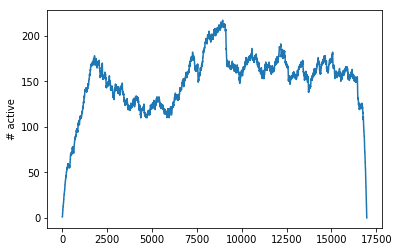

In [12]:
plt.plot(num_act_list)
plt.ylabel('# active')
plt.show()

In [13]:
def threshold_cal(datacolumn,to_integer=False):
    sorted(datacolumn)
    Th = np.percentile(datacolumn , [90])
    if to_integer==True:
        Th=int(Th)
    return Th

In [ ]:
##======================================Cal Prob================================================
es2 = sorting.sort_timestamp_stream(es1)

# end event number
num_events=es2.__len__()
# num_events=12000

# start event number
start_event=0
# window size
maxWinSize=5000

# pick a time scale for the statistic unit
# time_scale=60
time_scale=3600        #hours
# time_scale=3600*24     #days

# Dict:CaseIndNT record the {case-id:{index activity name: name, index activity time: time}}
CaseIndNT={}
# 
# index and event :time list
CaseIndTime={}
CaseEvtTime={}


# confusion matrix of predict complete and actual complete
df_ConfM = pd.DataFrame()

#  event stream SLinding window
esSL=[]

# for record the current index
i=start_event

# Statistic for first and last case-activity dict
first_act={}

# Drop Case List
DCL={}

# All activity counter
AllactL={}
AllactF={}
Lastact={}
Followact={}
Firstact={}

df_Last = pd.DataFrame()
df_Follow = pd.DataFrame()
df_First = pd.DataFrame()

for event in itertools.islice(es2 , start_event, num_events):

    glue = event[case_glue]
    current_time=event[xes.DEFAULT_TIMESTAMP_KEY]
    if event[xes.DEFAULT_NAME_KEY] not in AllactF:
        AllactL['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        AllactF['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        Lastact['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        Followact['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        Firstact['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
    AllactF['%s'%(event[xes.DEFAULT_NAME_KEY])]+=1
# start statistic of distribution
# Dict:CaseIndNT record the {case-id:{index activity name: name, index activity time: time}}
# Dict:CaseIndTime record the {index activity:[after index activity time]}
# Dict:CaseEvtTime record the {activity name:[after activity time]}
    if glue in DCL:
        if glue not in CaseIndNT.keys():
            Lastact['%s'%(DCL[glue]['act'])]-=1
            CaseIndNT[glue] = {}
            CaseIndNT[glue]['EvtIndex']=[DCL[glue]['index']+1]
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY]
            CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1])]=event[xes.DEFAULT_NAME_KEY]
            if (DCL[glue]['act']) not in CaseEvtTime:
                CaseEvtTime[DCL[glue]['act']] = []
            CaseEvtTime[DCL[glue]['act']].append((event[xes.DEFAULT_TIMESTAMP_KEY] - DCL[glue]['time']).total_seconds()/ time_scale)

            if ('time_after_%d'%(DCL[glue]['index'])) not in CaseIndTime:
                CaseIndTime['time_after_%d'%((DCL[glue]['index']))] = []
            CaseIndTime['time_after_%d'%(DCL[glue]['index'])].append((event[xes.DEFAULT_TIMESTAMP_KEY] -DCL[glue]['time']).total_seconds()/ time_scale)
            Followact['%s'%(DCL[glue]['act'])]+=1
        else:
            CaseIndNT[glue]['EvtIndex'].append(CaseIndNT[glue]['EvtIndex'][-1]+1)
            CaseIndNT[glue]['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] = (event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale
            CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1])] = event[xes.DEFAULT_NAME_KEY]
            if CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] not in CaseEvtTime:
                CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]] = []
            CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)

            if ('time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)) not in CaseIndTime:
                CaseIndTime['time_after_%d'%((CaseIndNT[glue]['EvtIndex'][-1]-1))] = []
            CaseIndTime['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY] 
            Followact['%s'%(CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)])]+=1  
    else:
        if glue not in CaseIndNT.keys():
            CaseIndNT[glue] = {}
            CaseIndNT[glue]['EvtIndex'] = [1]
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY]
            CaseIndNT[glue]['1_activity'] = event[xes.DEFAULT_NAME_KEY]
            Firstact['%s'%(event[xes.DEFAULT_NAME_KEY])]+=1
        else:
            CaseIndNT[glue]['EvtIndex'].append(CaseIndNT[glue]['EvtIndex'][-1]+1)
            CaseIndNT[glue]['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] = (event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale
            CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1])] = event[xes.DEFAULT_NAME_KEY]
            if CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] not in CaseEvtTime:
                CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]] = []
            CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)

            if ('time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)) not in CaseIndTime:
                CaseIndTime['time_after_%d'%((CaseIndNT[glue]['EvtIndex'][-1]-1))] = []
            CaseIndTime['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY]  
            # Count the follow activity 
            Followact['%s'%(CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)])]+=1   

# Do sliding window on list:esSL(event stream SLiding )
# Dropping from the front of sliding window
    if len(esSL) < maxWinSize:
        esSL.append(event)
    else:
        if len(CaseIndNT[esSL[0][case_glue]]['EvtIndex'])==1:
            # Count the last activity 
            Lastact['%s'%(esSL[0][xes.DEFAULT_NAME_KEY])]+=1   
            DCL[esSL[0][case_glue]]={}
            DCL[esSL[0][case_glue]]['index']=CaseIndNT[esSL[0][case_glue]]['EvtIndex'][-1]
            DCL[esSL[0][case_glue]]['act']=CaseIndNT[esSL[0][case_glue]]['%d_activity'%(CaseIndNT[esSL[0][case_glue]]['EvtIndex'][-1])]
            DCL[esSL[0][case_glue]]['time']=CaseIndNT[esSL[0][case_glue]]['event_time_newest']
            del CaseIndNT[esSL[0][case_glue]]
  
        else:
            del CaseIndNT[esSL[0][case_glue]]['%d_activity'%(CaseIndNT[esSL[0][case_glue]]['EvtIndex'][0])]
            del CaseIndNT[esSL[0][case_glue]]['time_after_%d'%(CaseIndNT[esSL[0][case_glue]]['EvtIndex'][0])]
            del CaseIndNT[esSL[0][case_glue]]['EvtIndex'][0]
# Count all the activity 
        AllactL['%s'%(esSL[0][xes.DEFAULT_NAME_KEY])]+=1

        del esSL[0]            
        esSL.append(event)

    Firstactdic={}
    for k in Firstact:
        if AllactF[k]>0:
            Firstactdic[k]=Firstact[k]/AllactF[k]
    df_First=df_First.append(Firstactdic , ignore_index=True)          

    Lastactdic={}
    for k in Lastact:
        if AllactL[k]>0:
            Lastactdic[k]=Lastact[k]/AllactL[k]
    df_Last=df_Last.append(Lastactdic , ignore_index=True)    

    Followactdic={}
    for k in Followact:
        if AllactF[k]>0:
            Followactdic[k]=1-Followact[k]/AllactF[k]
    df_Follow=df_Follow.append(Followactdic , ignore_index=True)   
    
    # for checking the code running state
    if (i%500==0):
        print(i,'/',(num_events))
    i=i+1

df_Last=df_Last.transpose()
df_Follow=df_Follow.transpose()
df_First=df_First.transpose()

In [ ]:
fig_row=2
fig_col = math.ceil(len(Followactdic)/fig_row)

f, axes = plt.subplots(fig_row,fig_col,figsize=(20,12))
i=1
for k in Followactdic:
#     print(k)
    plt.subplot(fig_row, fig_col, i)

#     plt.plot(df_Last.loc[ '%s'%k , :],'C0',label=('Last'))
#     plt.plot(df_Follow.loc[ '%s'%k , :],'C1',label=('Follow'))
    plt.plot(df_First.loc[ '%s'%k , :],'C1',label=('First'))
    plt.axhline(y=0.1, color='r',linestyle=':')
#     plt.axhline(y=0.05, color='b',linestyle=':')
#     plt.axhline(y=0.4, color='g',linestyle=':')
#     plt.axhline(y=0.3, color='m',linestyle=':')
    plt.axhline(y=0.9, color='r',linestyle=':')
    plt.ylim([0,1.05])
    plt.title('%s'%k,fontsize=24)
    plt.legend()
    i+=1
plt.show()

In [14]:
##======================================w/ DCL================================================
es2 = sorting.sort_timestamp_stream(es1)

# end event number
num_events=es2.__len__()
# num_events=11500

# start event number
start_event=0
# window size
maxWinSize=5000


# pick a time scale for the statistic unit
# time_scale=60
time_scale=3600        #hours
# time_scale=3600*24     #days

# probability threshold
prob_th=0.1
# Dict:CaseIndNT record the {case-id:{index activity name: name, index activity time: time}}
# Dict:CaseIndNT record the {case-id:{index activity name: name, index activity time: time}}
CaseIndNT={}
# 
IndQ={}
IndQ_hist={}
EvtQ={}
EvtQ_hist={}
# index and event :time list
CaseIndTime={}
CaseEvtTime={}


# confusion matrix of predict complete and actual complete
df_ConfM = pd.DataFrame()

#  event stream SLinding window
esSL=[]

# for record the current index
i=start_event

# Statistic for first and last case-activity dict
Firstact={}

# Drop Case List
DCL={}

# All activity counter
AllactL={}
AllactF={}
Lastact={}
Followact={}

df_Last = pd.DataFrame()
df_Follow = pd.DataFrame()
df_First = pd.DataFrame()

for event in itertools.islice(es2 , start_event, num_events):

    glue = event[case_glue]
    current_time=event[xes.DEFAULT_TIMESTAMP_KEY]
    if event[xes.DEFAULT_NAME_KEY] not in AllactF:
        AllactL['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        AllactF['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        Lastact['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        Firstact['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
        Followact['%s'%(event[xes.DEFAULT_NAME_KEY])]=0
    AllactF['%s'%(event[xes.DEFAULT_NAME_KEY])]+=1
# start statistic of distribution
# Dict:CaseIndNT record the {case-id:{index activity name: name, index activity time: time}}
# Dict:CaseIndTime record the {index activity:[after index activity time]}
# Dict:CaseEvtTime record the {activity name:[after activity time]}
    if glue in DCL:
        if glue not in CaseIndNT.keys():
            Lastact['%s'%(DCL[glue]['act'])]-=1
            CaseIndNT[glue] = {}
            CaseIndNT[glue]['EvtIndex']=[DCL[glue]['index']+1]
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY]
            CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1])]=event[xes.DEFAULT_NAME_KEY]
            if (DCL[glue]['act']) not in CaseEvtTime:
                CaseEvtTime[DCL[glue]['act']] = []
            CaseEvtTime[DCL[glue]['act']].append((event[xes.DEFAULT_TIMESTAMP_KEY] - DCL[glue]['time']).total_seconds()/ time_scale)

            if ('time_after_%d'%(DCL[glue]['index'])) not in CaseIndTime:
                CaseIndTime['time_after_%d'%((DCL[glue]['index']))] = []
            CaseIndTime['time_after_%d'%(DCL[glue]['index'])].append((event[xes.DEFAULT_TIMESTAMP_KEY] -DCL[glue]['time']).total_seconds()/ time_scale)
            Followact['%s'%(DCL[glue]['act'])]+=1
        else:
            CaseIndNT[glue]['EvtIndex'].append(CaseIndNT[glue]['EvtIndex'][-1]+1)
            CaseIndNT[glue]['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] = (event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale
            CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1])] = event[xes.DEFAULT_NAME_KEY]
            if CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] not in CaseEvtTime:
                CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]] = []
            CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)

            if ('time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)) not in CaseIndTime:
                CaseIndTime['time_after_%d'%((CaseIndNT[glue]['EvtIndex'][-1]-1))] = []
            CaseIndTime['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY] 
            Followact['%s'%(CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)])]+=1  
    else:
        if glue not in CaseIndNT.keys():
            CaseIndNT[glue] = {}
            CaseIndNT[glue]['EvtIndex'] = [1]
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY]
            CaseIndNT[glue]['1_activity'] = event[xes.DEFAULT_NAME_KEY]
            Firstact['%s'%(event[xes.DEFAULT_NAME_KEY])]+=1
        else:
            CaseIndNT[glue]['EvtIndex'].append(CaseIndNT[glue]['EvtIndex'][-1]+1)
            CaseIndNT[glue]['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] = (event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale
            CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1])] = event[xes.DEFAULT_NAME_KEY]
            if CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)] not in CaseEvtTime:
                CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]] = []
            CaseEvtTime[CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)]].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)

            if ('time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)) not in CaseIndTime:
                CaseIndTime['time_after_%d'%((CaseIndNT[glue]['EvtIndex'][-1]-1))] = []
            CaseIndTime['time_after_%d'%(CaseIndNT[glue]['EvtIndex'][-1]-1)].append((event[xes.DEFAULT_TIMESTAMP_KEY] - CaseIndNT[glue]['event_time_newest']).total_seconds()/ time_scale)
            CaseIndNT[glue]['event_time_newest'] = event[xes.DEFAULT_TIMESTAMP_KEY]  
            # Count the follow activity 
            Followact['%s'%(CaseIndNT[glue]['%d_activity'%(CaseIndNT[glue]['EvtIndex'][-1]-1)])]+=1   

# Calculate the statistic value by func:threshold_cal    Calculate every certain step 
    if (i%200==0):
# ============================event name threshold=========================================
        for idx in CaseEvtTime:
            EvtQ['%s'%idx]=threshold_cal(CaseEvtTime[idx],to_integer=True)
        for idx in CaseEvtTime:
            if idx not in EvtQ_hist:
                EvtQ_hist['%s'%idx]=[]
            EvtQ_hist['%s'%idx].append(threshold_cal(CaseEvtTime[idx],to_integer=True))
# ====================================================================================        
    
# Do sliding window on list:esSL(event stream SLiding )
# Dropping from the front of sliding window
    if len(esSL) < maxWinSize:
        esSL.append(event)
    else:
        if len(CaseIndNT[esSL[0][case_glue]]['EvtIndex'])==1:
            # Count the last activity 
            Lastact['%s'%(esSL[0][xes.DEFAULT_NAME_KEY])]+=1   
            DCL[esSL[0][case_glue]]={}
            DCL[esSL[0][case_glue]]['index']=CaseIndNT[esSL[0][case_glue]]['EvtIndex'][-1]
            DCL[esSL[0][case_glue]]['act']=CaseIndNT[esSL[0][case_glue]]['%d_activity'%(CaseIndNT[esSL[0][case_glue]]['EvtIndex'][-1])]
            DCL[esSL[0][case_glue]]['time']=CaseIndNT[esSL[0][case_glue]]['event_time_newest']
            del CaseIndNT[esSL[0][case_glue]]
  
        else:
            del CaseIndNT[esSL[0][case_glue]]['%d_activity'%(CaseIndNT[esSL[0][case_glue]]['EvtIndex'][0])]
            del CaseIndNT[esSL[0][case_glue]]['time_after_%d'%(CaseIndNT[esSL[0][case_glue]]['EvtIndex'][0])]
            del CaseIndNT[esSL[0][case_glue]]['EvtIndex'][0]
# Count all the activity 
        AllactL['%s'%(esSL[0][xes.DEFAULT_NAME_KEY])]+=1

        del esSL[0]            
        esSL.append(event)
        
    Firstactdic={}
    for k in Firstact:
        if AllactF[k]>0:
            Firstactdic[k]=Firstact[k]/AllactF[k]
    df_First=df_First.append(Firstactdic , ignore_index=True)  
    
    Lastactdic={}
    for k in Lastact:
        if AllactL[k]>0:
            Lastactdic[k]=Lastact[k]/AllactL[k]
    df_Last=df_Last.append(Lastactdic , ignore_index=True)    

    Followactdic={}
    for k in Followact:
        if AllactF[k]>0:
            Followactdic[k]=1-Followact[k]/AllactF[k]
    df_Follow=df_Follow.append(Followactdic , ignore_index=True)   
    

# Predict the complete log by our method
    StaResult={}
    pred_cpt_list=[]
    
    if (i >= 2000) and (i % 20 == 0):
#     if ((i==2080)):
# Turn the list esSL to event stream and then event log    
        ESSL=deepcopy(esSL)
        es3=log_instance.EventStream(ESSL, attributes=log.attributes, classifiers=log.classifiers,
                                        omni_present=log.omni_present, extensions=log.extensions)
        elog3 = to_event_log.transform_event_stream_to_event_log(es3)
        SLRf_net, SLRf_initial_marking, SLRf_final_marking=basic.apply(elog3)
        
        if soundness(SLRf_net, SLRf_initial_marking, SLRf_final_marking):
            fitness_RawSWf = alignment_based.apply(log,SLRf_net, SLRf_initial_marking, SLRf_final_marking)['averageFitness']
            precision_RawSWf = etconformance_token.apply(log, SLRf_net, SLRf_initial_marking, SLRf_final_marking)
            F1_RawSWf = 2*(fitness_RawSWf*precision_RawSWf)/(fitness_RawSWf+precision_RawSWf)     
        else:
            fitness_RawSW = 0
            precision_RawSW = 0   
            
# Find the complete trace in the SLiding window event log 
        WinTrlen = {}
        for case_index, case in enumerate(elog3):
            WinTrlen[case.attributes[xes.DEFAULT_TRACEID_KEY]]=elog3[case_index].__len__()
        complete_list=[]
        for k,v in WinTrlen.items():
            if v == tr_len[k]:
                complete_list.append(k)

        for k in CaseIndNT:
            StaResult[k]={}
            StaResult[k]['Predict']=False
            time_diff=(current_time - CaseIndNT[k]['event_time_newest']).total_seconds()/ time_scale  
            klast_act=CaseIndNT[k]['%d_activity'%(CaseIndNT[k]['EvtIndex'][-1])]
            
    #================================Condition of predict true===========================================
            if CaseIndNT[k]['EvtIndex'][0]==1:
                if (Firstactdic['%s'%CaseIndNT[k]['1_activity']] > prob_th):
                    if AllactF['%s'%klast_act] != 0:
                        if (Followactdic['%s'%CaseIndNT[k]['%d_activity'%CaseIndNT[k]['EvtIndex'][-1]]] > (1-prob_th)):
                            pred_cpt_list.append(k)
                        elif(Followactdic['%s'%CaseIndNT[k]['%d_activity'%CaseIndNT[k]['EvtIndex'][-1]]] > prob_th):
                            if (time_diff>=EvtQ['%s'%(CaseIndNT[k]['%d_activity'%(CaseIndNT[k]['EvtIndex'][-1])])]):
                                StaResult[k]['Predict']=True
                                pred_cpt_list.append(k)          
#     #====================================================================================================        
    #================================Condition of predict true  OnlyTime===========================================
#                         else:
#                             if (time_diff>=EvtQ['%s'%(CaseIndNT[k]['%d_activity'%(CaseIndNT[k]['EvtIndex'][-1])])]):
#                                 StaResult[k]['Predict']=True
#                                 pred_cpt_list.append(k)          
#     #====================================================================================================      
#             Actual complete 
            if k in complete_list:
                StaResult[k]['Actual']=True
            else:
                StaResult[k]['Actual']=False
                
        esSLPredCpt=[]
        for itessl in esSL:
            if itessl[case_glue] in pred_cpt_list:
                esSLPredCpt.append(itessl) 
                
        ESSL_PredCpt=deepcopy(esSLPredCpt)
        es3_PredCpt=log_instance.EventStream(ESSL_PredCpt, attributes=log.attributes, classifiers=log.classifiers,
                                        omni_present=log.omni_present, extensions=log.extensions)
        elog3_PredCpt = to_event_log.transform_event_stream_to_event_log(es3_PredCpt)
        SLF_net, SLF_initial_marking, SLF_final_marking = inductive_miner.apply(elog3_PredCpt) 
    
        fitness_FilSW = alignment_based.apply(log,SLF_net, SLF_initial_marking, SLF_final_marking)['averageFitness']
        precision_FilSW = etconformance_token.apply(log, SLF_net, SLF_initial_marking, SLF_final_marking)
        F1_FilSW = 2*(fitness_FilSW*precision_FilSW)/(fitness_FilSW+precision_FilSW)
        
        df_StaResult=pd.DataFrame.from_dict(StaResult).transpose()
        TP=len(df_StaResult[(df_StaResult['Predict']==True) & (df_StaResult['Actual']==True) ])
        FP=len(df_StaResult[(df_StaResult['Predict']==True) & (df_StaResult['Actual']==False) ])
        FN=len(df_StaResult[(df_StaResult['Predict']==False) & (df_StaResult['Actual']==True) ])
        TN=len(df_StaResult[(df_StaResult['Predict']==False) & (df_StaResult['Actual']==False) ])
        if ((TP+FP)==0):
            Precision=0
        else:
            Precision=TP/(TP+FP)
        if ((TP+FN)==0):
            Recall=0
        else:
            Recall=TP/(TP+FN)
        if ((Precision+Recall)==0):
            F1=0
        else:
            F1=2*(Precision*Recall)/(Precision+Recall)
        df_ConfM = df_ConfM.append({'index':i,'TP': TP,'FP':FP,'FN':FN,'TN':TN,'Precision':Precision,
                                    'PM_fitness_Rawf':fitness_RawSWf,'PM_precision_Rawf':precision_RawSWf,'PM_F1_Rawf':F1_RawSWf,
                                    'PM_fitness_Fil':fitness_FilSW,'PM_precision_Fil':precision_FilSW,'PM_F1_Fil':F1_FilSW,
                                    'Recall':Recall,'F1':F1},ignore_index=True)
#         df_ConfM = df_ConfM.append({'index':i,'PM_fitness_Fil':fitness_FilSW,'PM_precision_Fil':precision_FilSW,'PM_F1_Fil':F1_FilSW,
#                                     'PM_fitness_Rawf':fitness_RawSWf,'PM_precision_Rawf':precision_RawSWf,'PM_F1_Rawf':F1_RawSWf,
#                                     },ignore_index=True)                      
    
    # for checking the code running state
    if (i%500==0):
        print(i,'/',(num_events))
    i=i+1

df_Last=df_Last.transpose()
df_Follow=df_Follow.transpose()
df_First=df_First.transpose()

0 / 16973
500 / 16973
1000 / 16973
1500 / 16973
2000 / 16973
2500 / 16973


KeyboardInterrupt: 

In [ ]:
# EvtQ_hist
# pred_cpt_list
# time_diff

In [ ]:
# df_ConfM.to_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn3/new/MySyn1_noTime_Result.csv',index=False)
# df_ConfM = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn3/new/MySyn3_time.csv')
df_ConfM = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn1/MySyn1_noTime_Result.csv')

df_ConfM_noDCL = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn1/MySyn1_noDCL_Result.csv')
# df_ConfM_bigSW = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn1/MySyn1_bigSW_notime.csv')

# df_ConfM_noTime = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn3/new/MySyn3_notime.csv')
# df_ConfM_Time = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn3/MySyn3_onlytime.csv')


In [ ]:
# df_ConfM[df_ConfM['PM_F1_Fil']>0.7]
# df_ConfM_Time = df_ConfM
# df_ConfM

In [ ]:
# df_ConfM_noTime=df_ConfM_noTime[df_ConfM_noTime['index']<12000]
# df_ConfM=df_ConfM[df_ConfM['index']<12000]
# df_ConfM_noDCL=df_ConfM_noDCL[df_ConfM_noDCL['index']<12000]
P=(df_ConfM['TP']+df_ConfM['FN'])/(df_ConfM['TP']+df_ConfM['FN']+df_ConfM['FP']+df_ConfM['TN'])
F=2*P/(P+1)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax2 = plt.subplot(111)

ax2.plot(df_ConfM['index'],F,'k',label='All Predict True')
ax2.plot(df_ConfM['index'],(df_ConfM['PM_F1_Fil']),'-C0',label='Filtered ')
# ax2.plot(df_ConfM['index'],(df_ConfM['PM_F1_Raw']),'--C3',label='Raw')
ax2.plot(df_ConfM['index'],(df_ConfM['PM_F1_Rawf']),'--C1',label='Raw infrequent')
# ax2.plot(df_ConfM_noDCL['index'],(df_ConfM_noDCL['PM_F1_Fil']),'--C2',label='Filtered w/o DCL')
# ax2.plot(df_ConfM['index'],(df_ConfM['PM_F1_Rawf']),':C2',label='Raw - infrequent')
# ax2.plot(time2['index'],(time2['F1']),'C3',label='only start')
# ax2.title.set_text('F1 (Wsize=4k)')
ax2.legend()
plt.title('F1 ( fitness & precision )',fontsize=25)
# # plt.xlabel('test case')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(True)
# ax2.set_xlim([2000,12000])
ax2.set_ylim([0,1.05])
# plt.savefig('/home/tsai/Dropbox/Process_Mining/OutputData/W18/Real_life/BPI_2019_Consignment.png')
plt.show()

In [ ]:
# df_ConfM_noTime = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn2/MySyn2_noTime4k_Result.csv')
# df_ConfM_Time = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn2/time_Syn2.csv')
# df_ConfM_noTime = pd.read_csv('/home/tsai/Dropbox/Process_Mining/OutputData/W17/Real_life/BPI_2019_Consignment.csv')
# df_ConfM_noTime

In [ ]:
fig = plt.figure(figsize=(20,10))
ax2 = plt.subplot(111)

ax2.plot(df_ConfM['index'],F,'k',label='All Predict True')
ax2.plot(df_ConfM['index'],(df_ConfM['F1']),'C1',label='Filtered w/ DCL')
ax2.plot(df_ConfM_noDCL['index'],(df_ConfM_noDCL['F1']),'-C0',label='Filtered w/o DCL')
# ax2.plot(df_ConfM_Time['index'],(df_ConfM_Time['F1']),'--C2',label='Filtered only time')
# ax2.plot(time2['index'],(time2['F1']),'C3',label='only start')
# ax2.title.set_text('F1 (Wsize=4k)')
ax2.legend()
# plt.title('F1 ( Precision & Recall )',fontsize=25)
plt.xlabel('time step',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(True)
# ax2.set_xlim([2000,12000])
ax2.set_ylim([0,1.05])
# plt.savefig('/home/tsai/Dropbox/Process_Mining/OutputData/W17/MySyn3/MySyn3_5.png')
# plt.savefig('/home/tsai/Dropbox/Process_Mining/Thesis/Syn1_DCL.png')
plt.show()

In [ ]:
fig_row=2
fig_col = math.ceil(len(Followactdic)/fig_row)

f, axes = plt.subplots(fig_row,fig_col,figsize=(20,12))
i=1
for k in Followactdic:
#     print(k)
    plt.subplot(fig_row, fig_col, i)

    plt.plot(df_Last.loc[ '%s'%k , :],'C0',label=('Last'))
    plt.plot(df_Follow.loc[ '%s'%k , :],'C1',label=('Follow'))
#     plt.plot(df_First.loc[ '%s'%k , :],'C1',label=('First'))
    plt.title('%s'%k)
    plt.legend()
    i+=1

plt.show()

In [ ]:
import math

# fig_form
def plot_CaseEvtOrIndex(CaseTime,fig_row=2):
    fig_col = math.ceil(len(CaseTime)/fig_row)

    f, axes = plt.subplots(fig_row,fig_col,figsize=(20,12))
    i=1
    for k in CaseTime:
        plt.subplot(fig_row, fig_col, i)
        sns.distplot(CaseTime[k], hist=True, rug=True).set_title('%s'%k)
        plt.axvline(x=EvtQ[k], color='r',linestyle=':')

        i+=1
# plot_CaseEvtOrIndex(CaseIndTime,fig_row=2)
# plt.show()
plot_CaseEvtOrIndex(CaseEvtTime,fig_row=2)
# plt.savefig('/home/tsai/Dropbox/Process_Mining/OutputData/W18/Real_life/Consignment_time_dis.png')
plt.show()

In [ ]:
# len(elog3_PredCpt)

In [ ]:
for case_index, case in enumerate(elog3_PredCpt):
    print("\n case index: %d  case id: %s" % (case_index, case.attributes["concept:name"]))
    for event_index, event in enumerate(case):
        print("event index: %d  event activity: %s  timestamp: %s" % (event_index, event["concept:name"],event["time:timestamp"]))

In [ ]:
SLF_gviz_pn = pn_vis_factory.apply(SLF_net, SLF_initial_marking, SLF_final_marking)
pn_vis_factory.view(SLF_gviz_pn)

In [ ]:
fitness_wholeNet = alignment_based.apply(log, SLF_net, SLF_initial_marking, SLF_final_marking)
precision_wholeNet = etconformance_token.apply(log, SLF_net, SLF_initial_marking, SLF_final_marking)
print(fitness_wholeNet)
print('precision:',precision_wholeNet)

In [ ]:
# pn_vis_factory.save(SL_gviz_pn,'/home/tsai/Dropbox/Process_Mining/OutputData/SW_F1_lowpoint1_2.png')

In [ ]:
for case_index, case in enumerate(elog3):
    print("\n case index: %d  case id: %s" % (case_index, case.attributes["concept:name"]))
    for event_index, event in enumerate(case):
        print("event index: %d  event activity: %s  timestamp: %s" % (event_index, event["concept:name"],event["time:timestamp"]))

In [ ]:
SLR_gviz_pn = pn_vis_factory.apply(SLR_net, SLR_initial_marking, SLR_final_marking)
pn_vis_factory.view(SLR_gviz_pn)

In [ ]:
fitness_wholeNet = alignment_based.apply(elog3, SLR_net, SLR_initial_marking, SLR_final_marking)
precision_wholeNet = etconformance_token.apply(log, SLR_net, SLR_initial_marking, SLR_final_marking)
print(fitness_wholeNet)
print('precision:',precision_wholeNet)
# from pm4py.objects.petri.check_soundness import check_relaxed_soundness_net_in_fin_marking as soundness
# soundness(SLR_net, SLR_initial_marking, SLR_final_marking)
# if soundness(SLR_net, SLR_initial_marking, SLR_final_marking):
#     print('true')
# else:
#     print('false')